# AutoML Training Script

In this notebook, we do data exploration as well as model training

## Load Data

We begin with loading the data and examining the data available

In [1]:
import pandas as pd
import numpy as np
import pickle

df = pd.read_csv('AssetData_Historical.csv')#.drop(['Machine_ID', 'Latitude', 'Longitude'], 1) #LongLat not unique with District
df_test = pd.read_csv('AssetData_New.csv').drop(['Machine_ID', 'Latitude', 'Longitude'], 1) #LongLat not unique with District
df.head()

,Machine_ID,Density_Overload,Abnormal_Flow_Rate,Heat_Flow,Asset_Integrity,Temperature_Differential,Volumetric_Flow_Rate,Tangential_Stress,Duct_Lengths_in_Units,Fault_in_last_Month,...,Compression_Ratio,Multiple_Connects,Water_Exposure_units,Humidity_Factor,Cathodic_Protection,Pressure_Class,District,Latitude,Longitude,Failure_NextHour
0,111436,7877,2,7879,783360,1062,1576,1716,1978,0,...,3,785,3139,128,1,1,Rochor,"1,31","103,87",0
1,185081,7877,2,7879,783360,1062,1576,1716,1978,0,...,3,785,3139,128,1,1,Geylang West,"1,32","103,89",0
2,111413,7099,1,7100,783360,844,1682,1698,1715,0,...,3,722,2874,128,1,1,Hume Estate,"1,35","103,82",0
3,185070,7099,1,7100,783360,844,1682,1698,1715,0,...,3,722,2874,128,1,1,Little India,"1,31","103,85",0
4,111385,7797,3,7800,783360,1029,1604,1641,1880,0,...,3,836,4831,128,1,1,Jurong?esidential,"1,35","103,82",1


Immediately we realise that the Long/Lat columns are read at strings, particularly with ',' as decimal indicators. We write a simple script to clean the columns into compatible float values.

Furthermore, we see that the District Column matches the Long/Lat columns exactly. The Long/Lat columns potentially contains more information, and District column requires one-hot encoding. We decide to drop District column since it provides no additional information on top of Long/Lat.

In [2]:
df.drop(['Machine_ID', 'District'], axis=1, inplace=True)

In [3]:
def cleanLongLat(l):
    split = l.str.split(',', expand=True)
    split = (split[0]+'.'+[i if len(i)>1 else i+'0' for i in split[1]]).astype(float)
    return(split)

df['Latitude'] = cleanLongLat(df['Latitude'])
df['Longitude'] = cleanLongLat(df['Longitude'])

In [4]:
len(df['Asset_Integrity'].unique())

50

Note: We noticed that Asset Integrity only has 50 unique values. It is likely to be referring to categories of asset integrity. However, without any further information, we will leave it as integer values for the purpose of this exercise. More information about the data is required. 

Next, we want to do quick exploration. We begin with finding any missing entries, as well as looking at correlation between predictors and target variable

In [5]:
df.isnull().sum()

Density_Overload                   0
Abnormal_Flow_Rate                 0
Heat_Flow                          0
Asset_Integrity                    0
Temperature_Differential           0
Volumetric_Flow_Rate               0
Tangential_Stress                  0
Duct_Lengths_in_Units              0
Fault_in_last_Month                0
Avg_hours_in_Use                   0
Pressure_Alarm                     0
Inclination_Angle                  0
Location_Fault_Code                0
Operating_Pressure_above_Normal    0
Vandalism_Reports                  0
Compression_Ratio                  0
Multiple_Connects                  0
Water_Exposure_units               0
Humidity_Factor                    0
Cathodic_Protection                0
Pressure_Class                     0
Latitude                           0
Longitude                          0
Failure_NextHour                   0
dtype: int64

In [6]:
df.corr()

,Density_Overload,Abnormal_Flow_Rate,Heat_Flow,Asset_Integrity,Temperature_Differential,Volumetric_Flow_Rate,Tangential_Stress,Duct_Lengths_in_Units,Fault_in_last_Month,Avg_hours_in_Use,...,Vandalism_Reports,Compression_Ratio,Multiple_Connects,Water_Exposure_units,Humidity_Factor,Cathodic_Protection,Pressure_Class,Latitude,Longitude,Failure_NextHour
Density_Overload,1.000000,0.213953,0.816754,0.351662,0.377343,0.570871,0.556368,0.430534,-0.220760,0.577219,...,0.193853,0.679247,0.820239,0.908305,0.506550,-0.351434,0.408092,-0.010312,-0.004230,-0.087024
Abnormal_Flow_Rate,0.213953,1.000000,0.172850,-0.004151,0.124482,0.003325,0.008282,0.084355,0.011510,-0.000094,...,0.043134,0.087553,0.144965,0.218419,0.036166,-0.096641,0.106887,-0.004386,0.010395,-0.021901
Heat_Flow,0.816754,0.172850,1.000000,0.530835,0.465880,0.740692,0.724796,0.587358,-0.201193,0.744314,...,0.177770,0.632241,0.801082,0.788693,0.483371,0.132709,0.336258,-0.014915,-0.002667,-0.053134
Asset_Integrity,0.351662,-0.004151,0.530835,1.000000,0.258145,0.258186,0.237170,0.119656,-0.372188,0.276150,...,0.056072,0.622167,0.298326,0.292916,0.911570,0.248745,0.031216,-0.011228,0.002324,0.046219
Temperature_Differential,0.377343,0.124482,0.465880,0.258145,1.000000,0.183473,0.186437,0.382701,-0.074888,0.158436,...,0.085021,0.328921,0.474112,0.517217,0.234152,0.066515,0.210291,-0.009762,0.000105,-0.060799
Volumetric_Flow_Rate,0.570871,0.003325,0.740692,0.258186,0.183473,1.000000,0.990529,0.657269,-0.165331,0.985292,...,0.107318,0.411663,0.567000,0.487839,0.187735,0.176347,0.361949,-0.012698,-0.005900,-0.099991
Tangential_Stress,0.556368,0.008282,0.724796,0.237170,0.186437,0.990529,1.000000,0.681816,-0.162114,0.972280,...,0.122956,0.396725,0.560576,0.480895,0.166028,0.177116,0.365949,-0.013039,-0.005754,-0.105457
Duct_Lengths_in_Units,0.430534,0.084355,0.587358,0.119656,0.382701,0.657269,0.681816,1.000000,-0.136521,0.590984,...,0.063613,0.221804,0.490976,0.485157,0.043847,0.183283,0.377411,-0.017280,-0.004431,-0.181797
Fault_in_last_Month,-0.220760,0.011510,-0.201193,-0.372188,-0.074888,-0.165331,-0.162114,-0.136521,1.000000,-0.161808,...,-0.038184,-0.301645,-0.151786,-0.161859,-0.417224,0.091157,-0.057409,-0.000137,0.002422,0.021366
Avg_hours_in_Use,0.577219,-0.000094,0.744314,0.276150,0.158436,0.985292,0.972280,0.590984,-0.161808,1.000000,...,0.106568,0.417957,0.563756,0.478507,0.208780,0.169817,0.338580,-0.012246,-0.006712,-0.084762


We find no correlation values that require further attention, apart from Long/Lat being low. There are also no missing values.


Next, we want to check the proportion of machines that do fail

In [7]:
np.mean(df.Failure_NextHour)
#~18% failures, stratfify sampling for better accuracy

0.1788908254521558

We find that there is roughly 18% of failures in the data. Since the number of Failures is too low, we set custom weights for training. Otherwise, a model can achieve a baseline 82% accuracy simply by predicting no failures at all.


## Preprocessing
### Scaling

The next step is for preparing the data for training. We find the range of values in the columns to vary greatly, to ensure one variable does not outweigh the other in models that use objective functions in  $L^p$ space, we scale and center all columns, to preserve variance while removing "units". 

To scale new data, the mean and variance of training data is used. As such, we create a custom $\texttt{scaler}$ object that scales the data and saves the required variables for use in scoring later.

For an accurate look at our final model prediction accuracy, we split the data into training and test sets before we scale. The $\texttt{scaler}$ object will contain mean and variance learnt only on the training data. We also enforce a stratified split of the $y$ variable, to ensure a good estimate during testing.

In [8]:
X = df.drop('Failure_NextHour', 1)
y = df['Failure_NextHour']

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y)

As mentioned above, we will declare custom weights for training, with 4 times higher weight for Failures.

In [10]:
weights = np.array(y_train*4 + 1)

In [11]:
class scaler:
    def __init__(self, x = None):
        if type(x) == pd.core.frame.DataFrame:
            self.fit(x)
        elif x == None:
            self.x = None
            self.mean = None
            self.var = None
        else:
            raise Exception('Require pandas.DF input')


    def fit(self, x):
        self.x = x
        self.mean = x.mean()
        self.var = x.var()

    def scale(self, new_x):
        result = (new_x - self.mean) / np.sqrt(self.var)
        return (result)

In [12]:
s = scaler(X_train)

pickle.dump(s, open('scaler.pkl', 'wb'))
X_scale = s.scale(X_train)
X_scale.boxplot(rot=90) #Preserves corr, prevents skew for linear models, good for PCA

In the plot above we examine the variables post scaling. We identify some outliers in Abnormal_Flow_Rate. We would normally do further investigation into these outliers but without more information on what each column represents, we cannot confidently remove these. There are also not many outliers and will likely not skew the results too much.

At this point, we are done with data exploration and cleaning.

### Principal Component Analysis

We lack information about the data rows, and no insight on the machine the telemetry comes from. We can fix this issue by relying on PCA to pick out relevant variables.

$\textbf{NOTE}$: AutoML will try PCA in its pipeline. However, to generalise the data processing pipeline, this is left in and still done manually.

In [13]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scale)
pickle.dump(pca,open('pca_transform.pkl','wb'))
pcvars = pca.explained_variance_ratio_
print("Sum of first n PCs:")
print([sum(pcvars[:i+1]) for i in range(len(pcvars))])
princomps = pca.components_[:10].round(decimals = 3)
#print(princomps)
#for i in princomps:
#    print(X.columns[abs(i)>0.2])
#print(X.columns[abs(pca.components_[:2].round(decimals = 3))<0.1])

Sum of first n PCs:
[0.37820559844228124, 0.5049076698368848, 0.5859119941217747, 0.6408215017322727, 0.6936138946402464, 0.7423007066961939, 0.7882074267540906, 0.8291816447015157, 0.8668673776437148, 0.9014191977553901, 0.9220143275991884, 0.9384640503956475, 0.9520686893275901, 0.9631158462389907, 0.9734492851310932, 0.9833208860273237, 0.9898140717996832, 0.9948130545683288, 0.9974479691331665, 0.999109374045735, 0.9997325020816045, 0.999997149072198, 1.0]


We check the explained variance of the first $n \in (1,...,10)$ principal components. The first 10 PCs give 90% of accuracy, small increases after. Will use only 10 PCs for subsequent modelling.

In [14]:
X_pca = X_pca[:,:10]

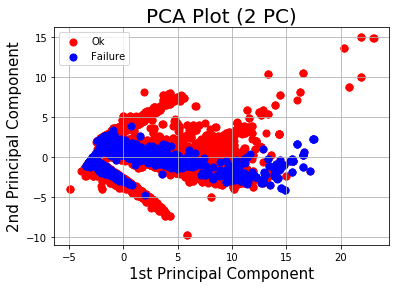

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('1st Principal Component', fontsize = 15)
ax.set_ylabel('2nd Principal Component', fontsize = 15)
ax.set_title('PCA Plot (2 PC)', fontsize = 20)

cols = ['r', 'b']
for f in [0,1]:
    idx = y_train == f
    ax.scatter(X_pca[idx, 0], X_pca[idx, 1], color = cols[f], s = 50)
    
ax.legend(['Ok','Failure'])
ax.grid()

If we examine the plot above. We see the first two PCs (total 50% explained variance) can already segment the Failures into a noticeable area of its own. This gives us confidence in using the PCs for modelling instead of the variables directly.

### AutoML Modelling

In this notebook, we will use AutoML for modelling for speed and scale. Begin with importing relevant modules and loading pre-configured workspace.

This is trained locally on a DSVM.

In [16]:
import azureml.core
azureml.core.VERSION

import logging
import os
import random

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

ws = Workspace.from_config()

exp_name = 'jmc-maintenance'
experiment=Experiment(ws, exp_name)
exp_list = ws.experiments

Found the config file in: C:\Users\zhpek\Desktop\C4TS-Challenge4\aml_config\config.json


We set up the training config, in this case, we use a simple 5-fold cross validation. We use custom weights as defined in the step above for training. We are concerned with false positives (wasting time maintaining healthy machines) as well as needing to ensure machines don't break down. This means recall and precision are extremely important, so we want to use weighted f1 sore as the primary metric. However, AutoML currently does not support f1 score, so we instead choose to optimise for average precision which also takes both precision and recall into account at this stage.

In [17]:
config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             primary_metric = 'average_precision_score_weighted',
                             iterations = 3,
                             n_cross_validations = 5,
                             verbosity = logging.INFO,
                             max_concurrent_iterations = 10,
                             sample_weight = weights,
                             X = X_pca, 
                             y = np.array(y_train))

The next cell creates a new run if this is the first run, but if an existing run has been conducted, then it continues the training. This facilitates retraining in the future, and does not "waste" the previous runs completed. At the end of training, we upload files required for preprocessing into the run itself.

In [21]:
if exp_name in exp_list:
    #AutoMLRun(experiment = experiment, run_id = run.id)
    run = AutoMLRun(experiment = experiment, run_id = list(experiment.get_runs())[0].id)
    run = run.continue_experiment(X = X_pca,
                                  y = np.array(y_train),
                                  show_output = True,
                                  sample_weight = weights,
                                  iterations = 30
                             )
else:
    run = experiment.submit(config, show_output=True) #

run.upload_file('pca_transform.pkl','pca_transform.pkl')
run.upload_file('scaler.pkl','scaler.pkl')

Parent Run ID: AutoML_682e01c5-d55f-4d45-8158-5db7c7a927c4
*******************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
*******************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   RobustScaler RandomForest                      0:00:48       0.6677    0.6677
         1   MaxAbsScaler LightGBM                          0:00:05       0.6866    0.6866
         2    Ensemble                                      0:00:08       0.6873    0.6873


From the runs completed, get the best model outputs and register them to Machine Learning Workspace.

In [22]:
best_iter, model = run.get_output()

We quickly check the model provided on our test data to estimate accuracy we can expect from our final model. Note that this is not necessarily the model we will use, since we will select based on a different metric

In [23]:
prediction = model.predict(pca.transform(X_test)[:,:10])
print('Accuracy: ' + str(np.mean(prediction == y_test)))
print('Recall: ' + str(np.mean(prediction[y_test==1] == 1)))
print('Precision: ' + str(np.mean(y_test[prediction==1] == 1)))
print('False Negatives: ' + str(np.mean(y_test[prediction==0] == 1))) #Missed this number of failures
print('False Positives: ' + str(np.mean(y_test[prediction==1] == 0))) #Checked unneccesarily

Accuracy: 0.7451428571428571
Recall: 0.07827476038338659
Precision: 0.1346153846153846
False Negatives: 0.1839923469387755
False Positives: 0.8653846153846154
